We will reproduce the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) here.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
print("The current HDDM version is: ", hddm.__version__)

0.8.0


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.7/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


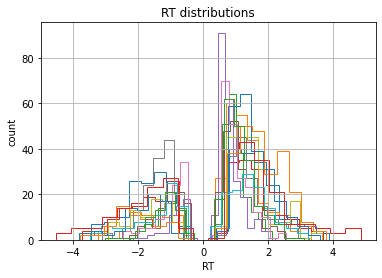

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [7]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model

#### Depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)
```

Here we defined a function for stimulus coding and used parallel processing

In [8]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [9]:
# define a function to run model in parallel
def run_m(id):
    print('running model (depends on stim) %i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(5000, burn=1000,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [10]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

m_stim_list = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
630.876s elapsed

running model (depends on stim) 0
 [-----------------100%-----------------] 5001 of 5000 complete in 624.1 sec
running model (depends on stim) 1
 [-----------------100%-----------------] 5000 of 5000 complete in 624.6 sec
running model (depends on stim) 2
 [-----------------98%----------------- ] 4934 of 5000 complete in 626.9 sec
running model (depends on stim) 3
 [-----------------99%----------------- ] 4955 of 5000 complete in 626.5 sec



Running 4 chains used: 645.897026 seconds.


In [13]:
m_stim_list = []
exp_name = 'cavanagh'
model_tag = 'm'
for i in range(4):
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%i 
    print(mname)
    m = hddm.load(mname)
    m_stim_list.append(m)

/home/jovyan/hddm/temp/df_cavanagh_m_chain_0
/home/jovyan/hddm/temp/df_cavanagh_m_chain_1
/home/jovyan/hddm/temp/df_cavanagh_m_chain_2
/home/jovyan/hddm/temp/df_cavanagh_m_chain_3


In [11]:
# m_stim_all = kabuki.utils.concat_models(m_stim_list) 

In [12]:
# v_WW, v_LL, v_WL = m_stim_all.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
# hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
# plt.xlabel('drift-rate')
# plt.ylabel('Posterior probability')
# plt.title('Posterior of drift-rate group means')
# # plt.savefig('hddm_demo_fig_06.pdf')

In [13]:
# print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
# print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

Get posterior predictions

Need to be parallalized in the future

In [15]:
df_stim_post_preds = []
for i in range(4):
    m = m_stim_list[i]
    df_post_pred = hddm.utils.post_pred_gen(m, samples = 4000)
    df_post_pred.reset_index(inplace=True)
    df_post_pred['chain'] = i
    df_post_pred.rename(columns={'sample':'draw',
                                 'level_2':'trial'}, inplace=True)
    print('\nchain', i, df_post_pred.shape)
    df_stim_post_preds.append(df_post_pred)

 [------------------107%------------------] 45 of 42 complete in 1939.3 sec
chain 0 (15952000, 6)
 [------------------107%------------------] 45 of 42 complete in 1948.2 sec
chain 1 (15952000, 6)
 [------------------107%------------------] 45 of 42 complete in 1986.9 sec
chain 2 (15952000, 6)
 [------------------107%------------------] 45 of 42 complete in 1928.8 sec
chain 3 (15952000, 6)


In [17]:
type(df_stim_post_preds)

list

In [18]:
# delete variables to save memory
del m
del df_post_pred

In [ ]:
# df_stim_post_preds = pd.concat(df_stim_post_preds)

## Convert HDDM objects to ArviZ?

Let's try to compare `m_stim_list` and `m_reg_list` in the above models.

To convert a `HDDM` object to an `ArviZ` InferenceData and use all the functionality of `ArviZ`, we need to convert the following parts:

* observed_data: the data on which the posterior is conditional. Each variable should have a counter part.

* Posterior: Samples from the posterior distribution $p(\theta | y)$, which is the trace from pymc.

* sample_stats: Information and diagnostics for each `posterior` sample, provided by the inference backend. 

* log_likelihood: pointwise log likelihood data. Sample shoudl match with `posteior` ones and its variables should match `observed_data` variables. 

* posterior_predictive: the posterior predictive distribution evaluated at the `observed_data`. Samples should match with `posterior` ones and its variables should match `observed_data` variables. The `observed_data` counterpart variable may have a different name.

* prior: Samples from the prior distriubtion $p(\theta)$. Samples need not to match `posterior`. still follow the convertion on `chain` and `draw` as first dimensions.

* prior_predictive. Samples from the `prior` predictive distribution. Samples should match `prior` samples and each variable should have a counterpart in `posterior_predictive/observed_data`.

In [19]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr

In [20]:
print("DIC of m_depends_on is %.5f" % m_stim_list[0].dic)

DIC of m_depends_on is 10787.02052


### `observed_data`

In this example data, we have 14 participants, each with three different conditions, each condition has different trial numbers.

In [21]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

In [22]:
data_tmp = data.copy()
data_tmp['trial'] = data_tmp.groupby(['subj_idx', 'stim']).cumcount()
data_tmp.drop(['theta','dbs','conf'], axis=1, inplace=True)
data_tmp.head()

,subj_idx,stim,rt,response,trial
0,0,LL,1.21,1.0,0
1,0,WL,1.63,1.0,0
2,0,WW,1.03,1.0,0
3,0,WL,2.77,1.0,1
4,0,WW,-1.14,0.0,1


In [23]:
data_tmp = data_tmp.set_index(["subj_idx", "stim", 'trial'])
xdata_observed = xr.Dataset.from_dataframe(data_tmp)
xdata_observed

<xarray.Dataset>
Dimensions:   (stim: 3, subj_idx: 14, trial: 157)
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156
Data variables:
    rt        (subj_idx, stim, trial) float64 1.21 2.0 1.72 1.72 ... nan nan nan
    response  (subj_idx, stim, trial) float64 1.0 1.0 1.0 1.0 ... nan nan nan

### `posterior`
The `posterior` is from the traces

In [24]:
df_stim_traces = []
for i in range(4):
    m = m_stim_list[i]
    df_trace = m.get_traces()
    df_trace['chain'] = i
    df_trace['draw'] = np.arange(len(df_trace), dtype=int)
    print('chain', i, df_trace.shape)
    df_stim_traces.append(df_trace)
df_stim_traces = pd.concat(df_stim_traces)
df_stim_traces = df_stim_traces.set_index(["chain", "draw"])

chain 0 (4000, 80)
chain 1 (4000, 80)
chain 2 (4000, 80)
chain 3 (4000, 80)


In [25]:
xposterior_stim = xr.Dataset.from_dataframe(df_stim_traces)
xposterior_stim

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 4000)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
Data variables: (12/78)
    a              (chain, draw) float64 2.06 1.879 2.141 ... 1.961 2.017 1.901
    a_std          (chain, draw) float64 0.368 0.3604 0.4548 ... 0.3988 0.3393
    a_subj.0       (chain, draw) float64 2.208 2.152 2.165 ... 2.209 2.141 2.172
    a_subj.1       (chain, draw) float64 2.124 2.135 2.139 ... 2.098 2.103 2.193
    a_subj.2       (chain, draw) float64 1.569 1.592 1.596 ... 1.552 1.564 1.527
    a_subj.3       (chain, draw) float64 2.255 2.049 2.082 ... 2.072 2.037 2.186
    ...             ...
    t_subj.8       (chain, draw) float64 0.5569 0.588 0.5745 ... 0.5249 0.5396
    t_subj.9       (chain, draw) float64 0.338 0.3819 0.3783 ... 0.379 0.3235
    t_subj.10      (chain, draw) float64 0.621 0.628 0.6545 ... 0.6532 0.6507
    t_subj.11      (chain, draw) float64 0.6304 0.6103 0.6104 ... 0.6216 0.6014
    t_subj.12      (chain, draw) float64 0.4003 0.3919 0.4009 ... 0.4084 0.3861
    t_subj.13      (chain, draw) float64 0.5042 0.5028 0.4938 ... 0.4865 0.4878

### `posterior_predictive`


In [26]:
df_stim_ppc = []
for i in range(4):
    df_post_pred = df_stim_post_preds[i]
    df_post_pred['chain'] = i
    # df_post_pred['draw'] = np.arange(len(df), dtype=int)
    # print('chain', i, df.shape)
    df_post_pred[['stim', 'subj_idx']] = df_post_pred['node'].str.split(pat='\.', expand=True)

    # extract the stim string between "(" and ")"

    df_post_pred['stim'] = df_post_pred['stim'].str.extract('.*\((.*)\).*')
    df_post_pred.drop('node', axis=1, inplace=True)
    df_stim_ppc.append(df_post_pred)

# df_stim_ppc = df_stim_traces.set_index(["chain", "draw"])

In [27]:
del df_post_pred

In [28]:
df_stim_ppc = pd.concat(df_stim_ppc)
df_stim_ppc.head()

,draw,trial,rt,response,chain,stim,subj_idx
0,0,0,-1.002044,0.0,0,LL,0
1,0,1,3.234144,1.0,0,LL,0
2,0,2,3.656644,1.0,0,LL,0
3,0,3,-2.642144,0.0,0,LL,0
4,0,4,-0.928644,0.0,0,LL,0


In [42]:
# # split the node column into stim and subj_idx

# # Need to find a better way, eat too much memory!

# # tmp_pred = df_stim_post_preds[0]
# df_stim_ppc[['stim', 'subj_idx']] = df_stim_ppc['node'].str.split(pat='\.', expand=True)

# # extract the stim string between "(" and ")"

# df_stim_ppc['stim'] = df_stim_ppc['stim'].str.extract('.*\((.*)\).*')
# df_stim_ppc.head()

,node,draw,trial,rt,response,chain,stim,subj_idx
0,wfpt(LL).0,0,0,-1.464745,0.0,0,LL,0
1,wfpt(LL).0,1,1,0.869045,1.0,0,LL,0
2,wfpt(LL).0,2,2,-1.579745,0.0,0,LL,0
3,wfpt(LL).0,3,3,1.416445,1.0,0,LL,0
4,wfpt(LL).0,4,4,0.854745,1.0,0,LL,0


In [ ]:
# #tmp_pred.groupby(['chain', 'draw','stim', 'trial']).size()
# df_stim_ppc.drop('node', axis=1, inplace=True)
# df_stim_ppc.head()

In [30]:
df_stim_ppc = df_stim_ppc.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
xdata_post_pred = xr.Dataset.from_dataframe(df_stim_ppc)
xdata_post_pred

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 4000, stim: 3, subj_idx: 14, trial: 157)
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 3993 3994 3995 3996 3997 3998 3999
  * subj_idx  (subj_idx) object '0' '1' '10' '11' '12' ... '5' '6' '7' '8' '9'
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156
Data variables:
    rt        (chain, draw, subj_idx, stim, trial) float64 -1.002 3.234 ... nan
    response  (chain, draw, subj_idx, stim, trial) float64 0.0 1.0 ... nan nan

In [31]:
InfData_stim = az.InferenceData(posterior=xposterior_stim, observed_data=xdata_observed,
                                posterior_predictive=xdata_post_pred)

InfData_stim

Inference data with groups:
	> posterior
	> posterior_predictive
	> observed_data

`az.plot_trace()` needs `chain`

To finished that, we need first understand the data structure, e.g., `c (chain, draw, c1, c2)`.

`az.hdi()` needs `chain`, `draw`

`az.loo()` and `az.waic()` needs `log likelihood`

### Tried to draw from prior (failed)

In [70]:
tmp = m_stim_list[0]
draw_from_prior(tmp, update=False)
# tmp.draw_from_prior(update=False)

AttributeError: Deterministic a_rate's value cannot be set.

In [50]:
df_stim_priors = []
for i in range(4):
    df = m_stim_list[i]
    df_prior = df.draw_from_prior()
    df_prior['chain'] = i
    df_prior['draw'] = np.arange(len(df_prior), dtype=int)
    print('chain', i, df_prior.shape)
    df_priors.append(df_trace)
df_stim_priors = pd.concat(df_stim_priors)
df_stim_priors = df_stim_priors.set_index(["chain", "draw"])

AttributeError: Deterministic a_rate's value cannot be set.

### try to get the posterior_predictive

In `post_pred_gen`, `samples` arugment define how many samples to generate for each node.

In the current case, our model has 4000 samples

In [96]:
tmp = m_stim_list[0]
tmp_ppc =hddm.utils.post_pred_gen(tmp)

 [------------------107%------------------] 45 of 42 complete in 242.3 sec

In [100]:
tmp_ppc.index.levels

FrozenList([['wfpt(LL).0', 'wfpt(LL).1', 'wfpt(LL).2', 'wfpt(LL).3', 'wfpt(LL).4', 'wfpt(LL).5', 'wfpt(LL).6', 'wfpt(LL).7', 'wfpt(LL).8', 'wfpt(LL).9', 'wfpt(LL).10', 'wfpt(LL).11', 'wfpt(LL).12', 'wfpt(LL).13', 'wfpt(WL).0', 'wfpt(WL).1', 'wfpt(WL).2', 'wfpt(WL).3', 'wfpt(WL).4', 'wfpt(WL).5', 'wfpt(WL).6', 'wfpt(WL).7', 'wfpt(WL).8', 'wfpt(WL).9', 'wfpt(WL).10', 'wfpt(WL).11', 'wfpt(WL).12', 'wfpt(WL).13', 'wfpt(WW).0', 'wfpt(WW).1', 'wfpt(WW).2', 'wfpt(WW).3', 'wfpt(WW).4', 'wfpt(WW).5', 'wfpt(WW).6', 'wfpt(WW).7', 'wfpt(WW).8', 'wfpt(WW).9', 'wfpt(WW).10', 'wfpt(WW).11', 'wfpt(WW).12', 'wfpt(WW).13'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,

Comparing the post predictive check, we can found that `node` represents the combination of conditions and participants, `sample` is the number of samples, and `level_2` is corresponding to trial number

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ce1ccdd10>,
      dtype=object)

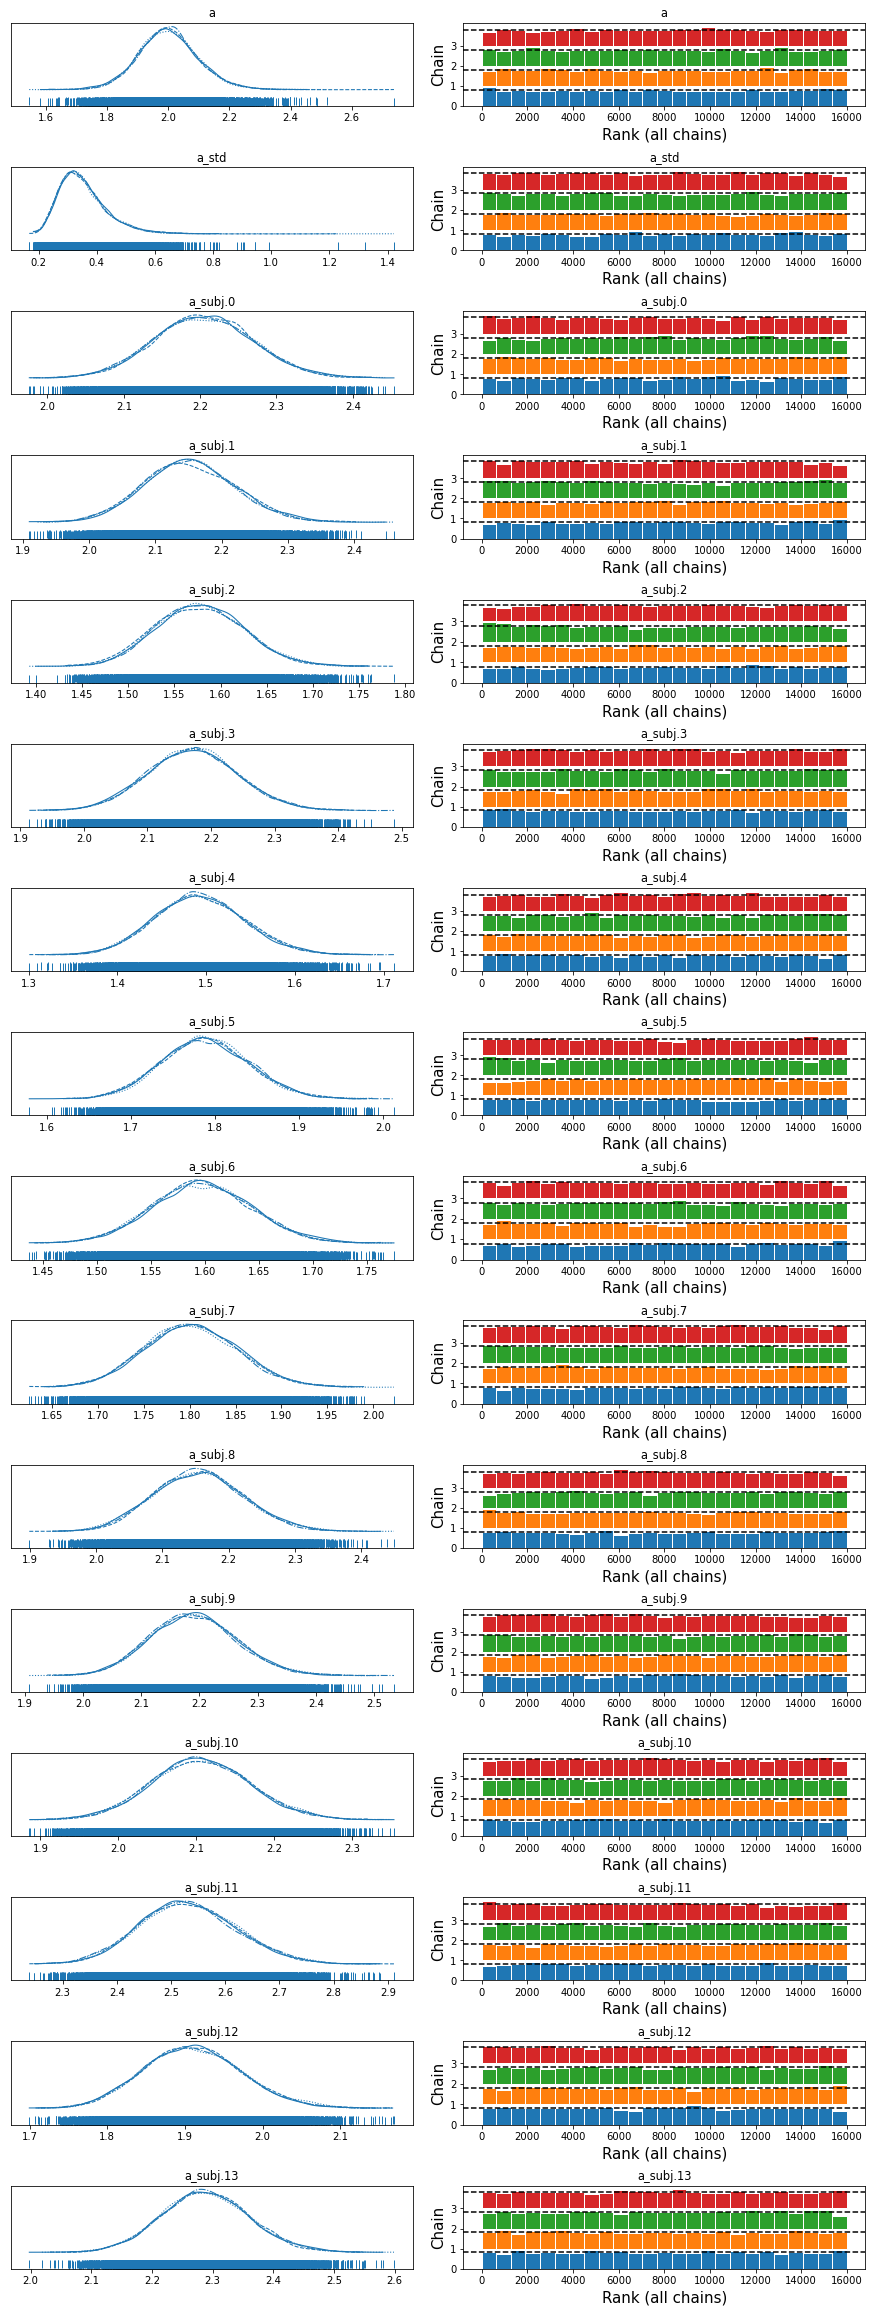

In [32]:
az.plot_trace(InfData_stim, var_names=("^a"), filter_vars='regex', rug=True, kind="rank_bars")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ce27dec50>],
      dtype=object)

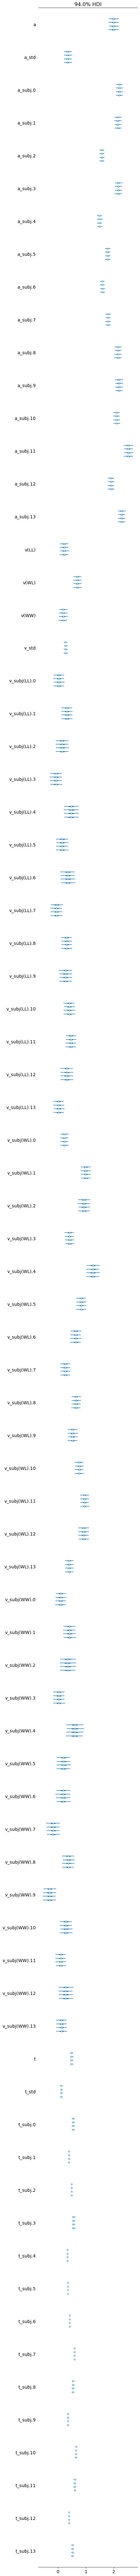

In [33]:
az.plot_forest(InfData_stim)

In [34]:
az.hdi(InfData_stim)

<xarray.Dataset>
Dimensions:        (hdi: 2)
Coordinates:
  * hdi            (hdi) <U6 'lower' 'higher'
Data variables: (12/78)
    a              (hdi) float64 1.816 2.183
    a_std          (hdi) float64 0.2169 0.5056
    a_subj.0       (hdi) float64 2.085 2.328
    a_subj.1       (hdi) float64 2.027 2.284
    a_subj.2       (hdi) float64 1.491 1.669
    a_subj.3       (hdi) float64 2.035 2.304
    ...             ...
    t_subj.8       (hdi) float64 0.4976 0.5929
    t_subj.9       (hdi) float64 0.326 0.3984
    t_subj.10      (hdi) float64 0.6205 0.6914
    t_subj.11      (hdi) float64 0.5637 0.6543
    t_subj.12      (hdi) float64 0.3734 0.4237
    t_subj.13      (hdi) float64 0.474 0.575

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ce3960ad0>,
      dtype=object)

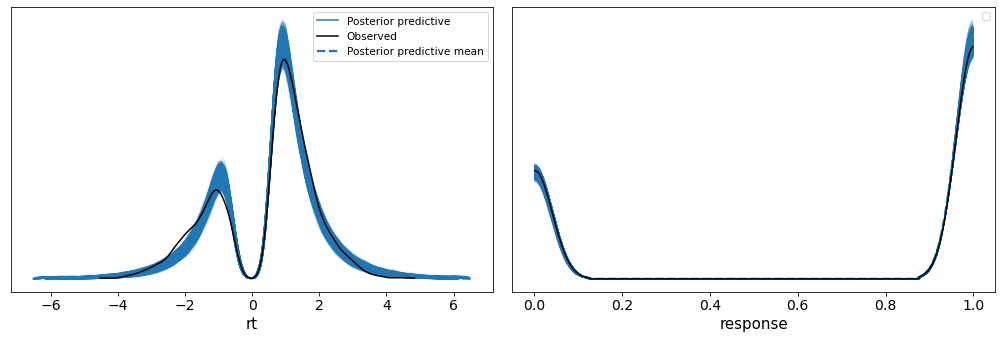

In [36]:
az.plot_ppc(InfData_stim)

In [46]:
az.loo(df_stim)

TypeError: log likelihood not found in inference data object

In [64]:
az.waic(df_reg)

TypeError: log likelihood not found in inference data object

In [41]:
datadict = {
    "a": np.random.randn(10),
    "b": np.random.randn(1, 10, 10),
    "c": np.random.randn(1, 10, 3, 4),
}

coords = {"c1": np.arange(3), "c2": np.arange(4), "b1": np.arange(10)}

dims = {"b":["b1"], "c":["c1", "c2"]}

dataset = az.convert_to_inference_data(datadict, coords=coords, dims=dims)
dataset

Inference data with groups:
	> posterior